In [1]:
import functools
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL']='0'
#os.environ['CUDA_LAUNCH_BLOCKING']='1'
import collections
import contextlib
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
from jax import lax
from jax import random
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from tensorflow_probability.substrates.jax.internal.dtype_util
from tensorflow_probability.substrates import jax as tfp
import jax.profiler

tfd = tfp.distributions
tfb = tfp.bijectors
tfm = tfp.mcmc
tfed = tfp.experimental.distribute
tfde = tfp.experimental.distributions
tfem = tfp.experimental.mcmc

Root = tfed.JointDistributionCoroutine.Root
import pandas as pd
data = pd.read_pickle('/home/dkn16/data.pkl')
FGnopol = data.beam.foregrounds.all_nopol
FGpol = data.beam.foregrounds.pleak
HI = data.beam.HI
noise = data.beam.noise
freqs = data.freqs
#matplotlib.use("Agg")  # noqa: E402

2022-12-26 10:17:20.718074: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64:/work/dkn16/jax-env/lib:/home/dkn16/.local/lib/python3.7/site-packages:/usr/lib64:/work/dkn16/jax-env/lib:/home/dkn16/.local/lib/python3.7/site-packages:/opt/gsl/2.6/lib
2022-12-26 10:17:20.718145: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64:/work/dkn16/jax-env/lib:/home/dkn16/.local/lib/python3.7/site-packages:/usr/lib64:/work/dkn16/jax-env/lib:/home/dkn16/.local/lib/python3.7/site-packages:/opt/gsl/2.6/lib
2022-12-26 10:17:20.718150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlo

In [2]:
print(jax.devices())

[StreamExecutorGpuDevice(id=0, process_index=0), StreamExecutorGpuDevice(id=1, process_index=0), StreamExecutorGpuDevice(id=2, process_index=0), StreamExecutorGpuDevice(id=3, process_index=0)]


In [3]:

# create artificial regression dataset
def get_data(dim,pol=False,x0=0,y0=0,freqs = 285):
    #idx=np.random.randint(1,6)
    #loc_idx=np.random.randint(48)
    
    #foreground
    if pol:
        sky = jnp.array(FGnopol+FGpol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    else:
        sky = jnp.array(FGnopol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    #HI signal
    cosmos = jnp.array(HI+noise)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    sky = sky - jnp.mean(sky,axis=(0,1))
    cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
    
    sky=sky.reshape((dim*dim,freqs))/1000
    cosmos=cosmos.reshape((dim*dim,freqs))/1000
    
    np.random.seed(0)
    X = jnp.linspace(0., 1., sky.shape[1]).astype(jnp.float64)#,dtype = jnp.float64)
    #Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    #Y += sigma_obs * np.random.randn(N)
    #Y -= jnp.mean(Y)
    #Y /= jnp.std(Y)

    #assert X.shape == (N,)
    #assert Y.shape == (N,)

    X_test = jnp.linspace(0., 1.,sky.shape[1]).astype(jnp.float64)#,dtype = jnp.float64)

    return X, sky+cosmos, X_test

In [4]:
def shard_value(x):
    x = x.reshape((jax.device_count(), -1, *x.shape[1:]))
    return jax.pmap(lambda x: x)(x) # pmap will physically place values on devices

shard = functools.partial(jax.tree_map, shard_value)
X, Y, X_test = get_data(256,pol=True,freqs=256)
#Y=jnp.ones((256*256,260),dtype=jnp.float64)
Y = shard(Y)
Y.shape

(4, 16384, 256)

In [5]:
#This is 'one parameter for all'

from jax.experimental.host_callback import call
dtype = jnp.float64
#@jax.default_matmul_precision('float32')
@functools.partial(jax.pmap, axis_name='data', in_axes=(None, None,0), out_axes=(None,None))
def run(seed, X, data):
    #data = Y # a sharded dataset
    num_examples, dim = data.shape
    #num_classes = 10
    # this is our model 
    def kernel_pol(X, Z, var, length,var_pol,length_pol,var_HI,length_HI, noise, jitter=dtype(1.0e-12),is_noise=True):
        deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
        deltapol = jnp.power((X[:, None] - Z) / length_pol, 2.0)
        deltaHI = jnp.abs((X[:, None] - Z) *100/ length_HI)

        k_fg = 1.0e-2*var * jnp.exp(-0.5 * deltaXsq)
        k_pol = 1.0e-6*var_pol * jnp.exp(-0.5 * deltapol)
        k_HI = 1.0e-9*var_HI * jnp.exp(-0.5 * deltaHI)
        #k = var * jnp.exp(-0.5 * deltaXsq)
        if is_noise:
            k_HI += (noise*noise*1.0e-12 + jitter) * jnp.eye(X.shape[0])
            k_fg += k_HI
        return k_fg+k_pol
    
    def model_fn():
        var_fg = yield Root(tfd.Sample(tfd.HalfNormal(dtype(1.)), 1))
        length_fg = yield Root(tfd.Sample(tfd.InverseGamma(dtype(2.),dtype(1.)), 1))
        
        var_pol = yield Root(tfd.Sample(tfd.HalfNormal(dtype(5.)), 1))
        length_pol = yield Root(tfd.Sample(tfd.InverseGamma(dtype(5.),dtype(1.)), 1))
        
        var_HI = yield Root(tfd.Sample(tfd.HalfNormal(dtype(1.)), 1))
        length_HI = yield Root(tfd.Sample(tfd.HalfNormal(dtype(1.)), 1))
        
        #print(var.shape
        noise = yield Root(tfd.Sample(tfd.HalfNormal(dtype(1.)), 1))
        
        #logits = jnp.dot(images, w) + b
        k =jax.vmap(lambda var_fg, length_fg,var_pol,length_pol,var_HI,length_HI, noise: kernel_pol(X, X, var_fg, length_fg,var_pol,length_pol,var_HI,length_HI, noise))(var_fg, length_fg,var_pol,length_pol,var_HI,length_HI, noise)
        #k = kernel_pol(X, X, var_fg, length_fg,var_pol,length_pol,var_HI,length_HI, noise)
        #print(k.shape)
        #yield tfed.Sharded(tfd.MultivariateNormalFullCovariance(loc = jnp.zeros(dim,dtype=jnp.float64),covariance_matrix = k),
        #                   shard_axis_name='data')
        yield tfed.Sharded(tfd.Independent(tfd.MultivariateNormalFullCovariance(loc = jnp.zeros((num_examples,dim),dtype=jnp.float64),covariance_matrix = k),1),
                           shard_axis_name='data')
    model = tfed.JointDistributionCoroutine(model_fn)
    #print('yes')
    init_seed, sample_seed = random.split(seed)

    initial_state = model.sample(seed=init_seed)[:-1] # throw away `y`
    #print(initial_state)

    def target_log_prob(*state):
        return model.log_prob((*state, data))
    #print(target_log_prob(*initial_state))
    #def accuracy(w, b):
    #    logits = images.dot(w) + b
    #    preds = logits.argmax(axis=-1)
        # We take the average accuracy across devices by using `lax.pmean`
    #    return lax.pmean((preds == labels).mean(), 'data')

    kernel = tfm.NoUTurnSampler(target_log_prob, 1e-2,max_tree_depth=8)
    kernel = tfm.DualAveragingStepSizeAdaptation(kernel,800,target_accept_prob=0.8)
    def trace_fn(state, pkr):
        log_prob = target_log_prob(*state)
        call(lambda x: print(f"step: {x[0]},leap_frogs: {x[1]},step_size: {x[2]:.2g},accept_ratio:{x[3]:.3f},log_prob:{x[4]:.2f} \n "), (pkr.step,pkr.inner_results.leapfrogs_taken,pkr.new_step_size,10**pkr.inner_results.log_accept_ratio,log_prob))
        #call(lambda x: print(f"leap_frogs: {x}"), pkr.inner_results.leapfrogs_taken)
        #call(lambda x: print(f"step_size: {x}"), pkr.new_step_size)
        
        return (
            log_prob,
            pkr.inner_results.has_divergence,
            10**pkr.inner_results.log_accept_ratio,
            #accuracy(*state),
            pkr.new_step_size,
        )
    states,traces = tfm.sample_chain(
            num_results=20,
            #num_burnin_steps=1000,
            current_state=initial_state,
            kernel=kernel,
            trace_fn=trace_fn,
            seed=sample_seed,
        )
    return states, traces

In [7]:
%%time
states, traces = run(random.PRNGKey(42),X,Y)
#states[0].block_until_ready()
jax.profiler.save_device_memory_profile("memory.prof")
#jnp.save('states.npy',states)

2022-12-21 15:10:14.269187: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:752] failed to free device memory at 0x152b8e2a3a00; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2022-12-21 15:10:14.269208: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:752] failed to free device memory at 0x152b8e2a3e00; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2022-12-21 15:10:14.269211: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:752] failed to free device memory at 0x152b8e2a4000; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2022-12-21 15:10:14.269214: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:752] failed to free device memory at 0x152b8e2a4200; result: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2022-12-21 15:10:14.2692

XlaRuntimeError: INTERNAL: Unable to launch triangular solve: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).

In [7]:
states

StructTuple(
  var0=ShardedDeviceArray([[1.35610903],
                        [1.35610903],
                        [1.35610903],
                        [1.35610903],
                        [1.35599567],
                        [1.35594322],
                        [1.35542856],
                        [1.35538702],
                        [1.3551824 ],
                        [1.35246042],
                        [1.35064342],
                        [1.34660329],
                        [1.34660329],
                        [1.34656607],
                        [1.34660685],
                        [1.34781551],
                        [1.35172352],
                        [1.35172352],
                        [1.35172314],
                        [1.35255294]], dtype=float64),
  var1=ShardedDeviceArray([[0.17972349],
                        [0.17972349],
                        [0.17972349],
                        [0.17972349],
                        [0.18824025],
              

In [20]:
states = jnp.load('states_realisticmodel_distributed.npy',allow_pickle=True).item()
X, Y, X_test = get_data(256,pol=True,freqs=256)
# squared exponential kernel with diagonal noise term
def kernel_pol(X, Z, var, length,var_pol,length_pol,var_HI,length_HI, noise, jitter=dtype(1.0e-12),is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    deltapol = jnp.power((X[:, None] - Z) / length_pol, 2.0)
    deltaHI = jnp.abs((X[:, None] - Z) *100/ length_HI)

    k_fg = 1.0e-2*var * jnp.exp(-0.5 * deltaXsq)
    k_pol = 1.0e-6*var_pol * jnp.exp(-0.5 * deltapol)
    k_HI = 1.0e-9*var_HI * jnp.exp(-0.5 * deltaHI)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k_HI += (noise*noise*1.0e-12 + jitter) * jnp.eye(X.shape[0])
        k_fg += k_HI
    return k_fg

def predict(rng_key, X, Y, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel_pol(X_test, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=False)
    k_pX = kernel_pol(X_test, X, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=False)
    k_XX = kernel_pol(X, X, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    #K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    #sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
    #    rng_key, X_test.shape[:1]
    #)
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y.T)).T
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean#, mean + sigma_noise
vmap_args = (
    random.split(random.PRNGKey(3), 50),
    states['param_0'][950:1000,0],
    states['param_1'][950:1000,0],
    states['param_2'][950:1000,0],
    states['param_3'][950:1000,0],
    states['param_4'][950:1000,0],
    states['param_5'][950:1000,0],
    states['param_6'][950:1000,0]
)
means = jax.vmap(
        lambda rng_key, var, length,var_pol, length_pol,var_HI, length_HI, noise: predict(
            rng_key, X, Y, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise
        )
    )(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(means, [5.0, 95.0], axis=0)

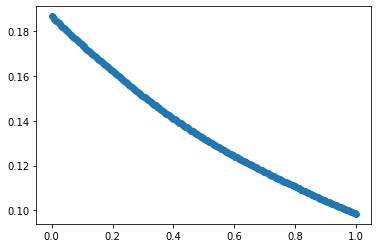

In [24]:
Y1=Y
plt.fill_between(X, percentiles[0, 300,:], percentiles[1, 300,:], color="lightblue")
plt.scatter(X,Y1[300])
plt.plot(X,mean_prediction[300])


In [35]:
states['param_5'][950:1000,0]

DeviceArray([18.67542435, 18.67541294, 18.67177553, 18.67264678,
             18.67073806, 18.6732376 , 18.67385245, 18.68670705,
             18.6882386 , 18.6888984 , 18.68702577, 18.68702577,
             18.68637625, 18.68697561, 18.68496906, 18.68386929,
             18.69738407, 18.69896681, 18.70609761, 18.70608188,
             18.72204235, 18.72576243, 18.72422413, 18.72476873,
             18.73577385, 18.7521817 , 18.75676346, 18.76092439,
             18.75651548, 18.7569689 , 18.7579723 , 18.75566821,
             18.77185516, 18.76881806, 18.7684121 , 18.78627601,
             18.79361548, 18.79265592, 18.79260769, 18.80934026,
             18.80853485, 18.80810798, 18.808217  , 18.8084303 ,
             18.81446753, 18.81220882, 18.82194527, 18.82238737,
             18.82398201, 18.82435224], dtype=float64)

In [36]:
cosmos = jnp.array(HI+noise)[:,:,0:256].astype(jnp.float64)
    
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
cosmos = cosmos.reshape((256*256,256))

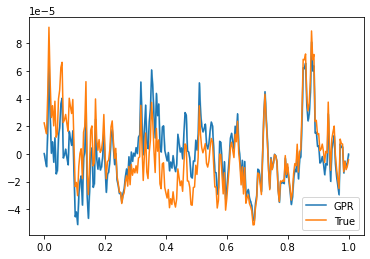

In [47]:
i=42286
plt.plot(X,Y1[i]-mean_prediction[i])

plt.plot(X,cosmos[i]/1000)
plt.fill_between(X_test,Y1[i]-percentiles[0, i,:], Y1[i]-percentiles[1, i,:], color="lightblue")
plt.legend(['GPR','True'])

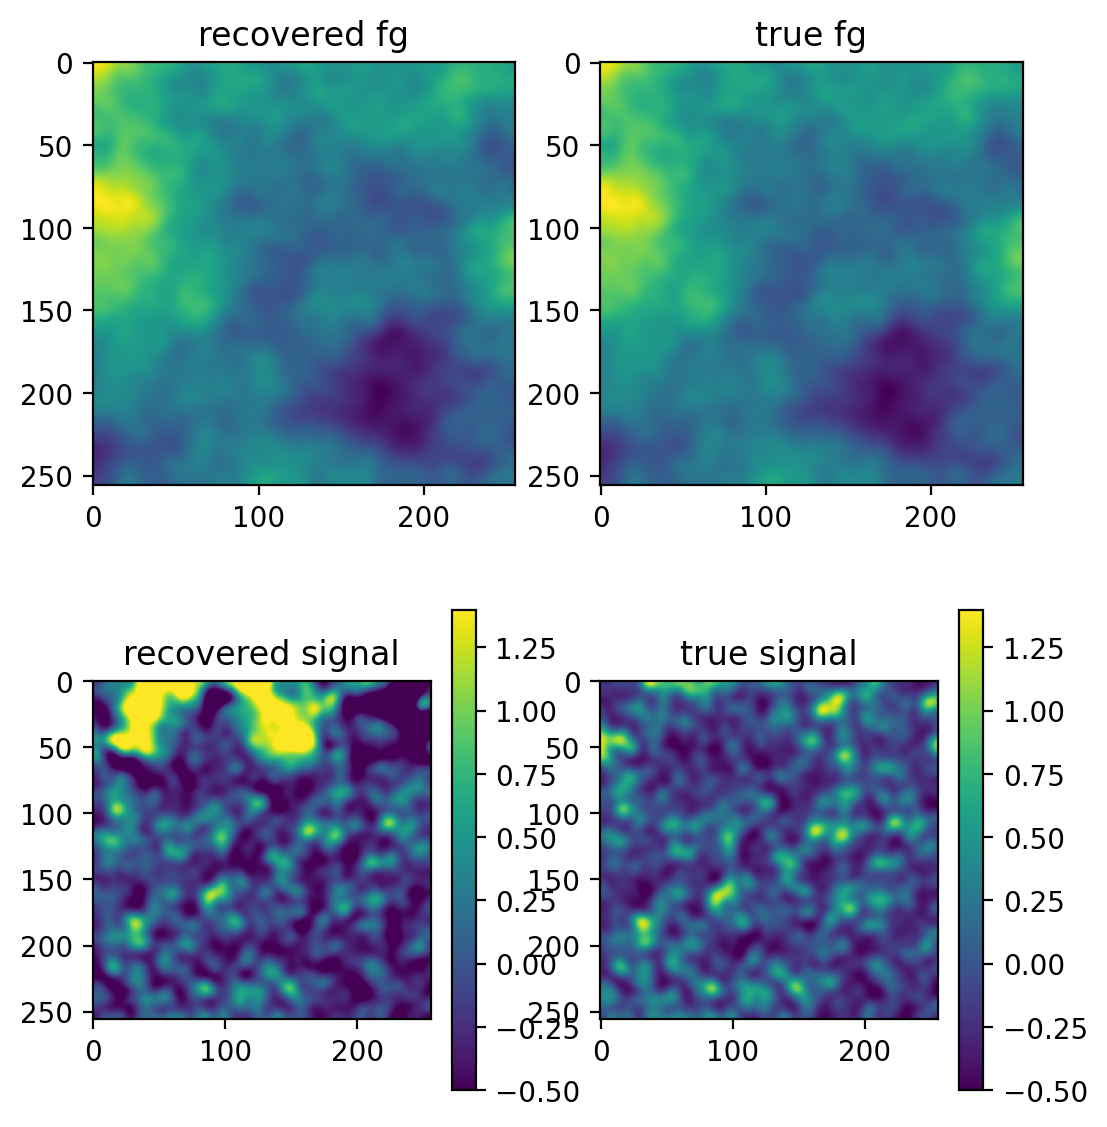

In [54]:
i=50
plt.figure(figsize=(6,7),dpi=200)
plt.subplot(2,2,1)
plt.imshow(mean_prediction[:,i].reshape(256,256))
plt.title('recovered fg')
plt.subplot(2,2,2)
plt.imshow(Y1[:,i].reshape(256,256))
plt.title('true fg')
plt.subplot(2,2,3)
plt.imshow((Y1[:,i]-mean_prediction[:,i]).reshape(256,256)*10000,vmin=-0.5,vmax=1.4)
plt.title('recovered signal')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(cosmos[:,i].reshape(256,256)*10,vmin=-0.5,vmax=1.4)
plt.title('true signal')
plt.colorbar()

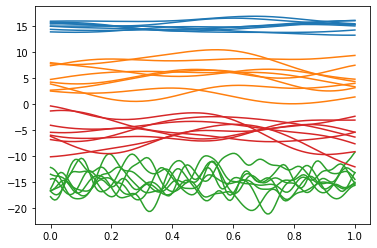

In [25]:
k1 = kernel(X, X,  0.052016747, 0.23297304, 1.81647456)
k2 = kernel(X, X,  1.52016747, 0.23297304, 1.81647456)
k3 = kernel(X, X,  0.52016747, 0.23297304, 1.81647456)
k4 = kernel(X, X,  0.52016747, 0.03297304, 1.81647456)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
samp = numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((2,2,X.shape[0])), covariance_matrix=[[k1,k2],[k3,k4]]),
        #obs=Y,
        rng_key= rng_key,sample_shape=(8,)
    )
for i in range(8):
    plt.plot(X,samp[i][0][0]+15,c='tab:blue')
    plt.plot(X,samp[i][1][0]+5,c='tab:orange')
    plt.plot(X,samp[i][0][1]-5,c='tab:red')
    plt.plot(X,samp[i][1][1]-15,c='tab:green')

In [160]:
numpyro.sample("kernel_var", dist.InverseGamma(10,2),rng_key= rng_key,sample_shape=(16,))

DeviceArray([0.16593575, 0.35661613, 0.44178466, 0.23166905, 0.19851243,
             0.26369422, 0.13496179, 0.21433583, 0.18115296, 0.14783476,
             0.28515543, 0.13975012, 0.13496239, 0.17410843, 0.21726044,
             0.12075873], dtype=float64)

In [30]:
percentiles.shape

(2, 10, 150)

In [125]:
Y.shape

(4096, 150)

In [110]:
k = kernel(X, X, 0.52016747, 0.23297304, 1.81647456)
jnp.mean(dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k).log_prob(Y))

DeviceArray(1264.82178955, dtype=float64)

In [170]:
samples

{'kernel_length': DeviceArray([0.42302552, 0.42301878, 0.42302362, 0.42301987, 0.42302611,
              0.42302386, 0.42301263, 0.42300984, 0.42300949, 0.42300693,
              0.42301815, 0.42301443, 0.42302797, 0.42303227, 0.42302964,
              0.4230277 , 0.42303511, 0.42303283, 0.42303401, 0.42303393,
              0.4230301 , 0.42302349, 0.42302522, 0.42302567, 0.42302858,
              0.42303519, 0.42303757, 0.42303275, 0.42303534, 0.42304212,
              0.42303208, 0.42303007, 0.42303806, 0.42303085, 0.42302919,
              0.42302831, 0.42302581, 0.42301978, 0.42301602, 0.42301501,
              0.42300887, 0.42299479, 0.42298329, 0.42298619, 0.42299007,
              0.42299533, 0.422989  , 0.42298821, 0.42299028, 0.42298966],            dtype=float64),
 'kernel_noise': DeviceArray([1.80610243, 1.80609536, 1.80603133, 1.80598893, 1.8059467 ,
              1.80592032, 1.8059154 , 1.80593716, 1.80591137, 1.80589166,
              1.80587565, 1.80587742, 1.80590157, 1

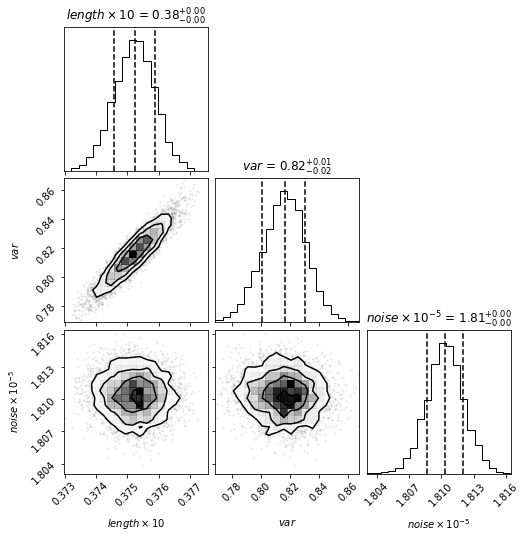

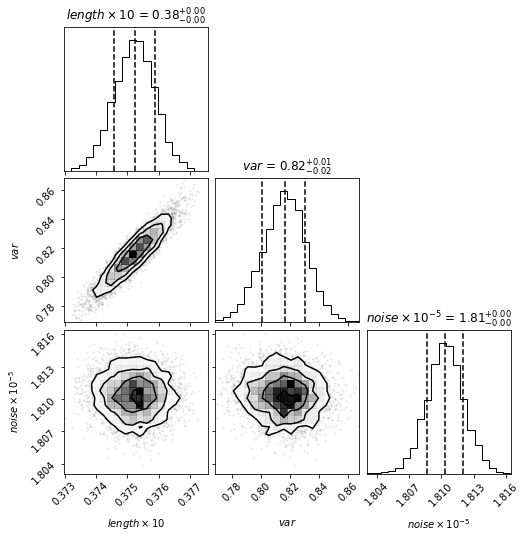

In [16]:
import corner
data = np.vstack([samples['kernel_length'],samples['kernel_var'],samples['kernel_noise']]).T
corner.corner(data,labels=[
        r"$length\times 10$",
        r"$var$",
        r"$noise\times 10^{-5}$",
    ],quantiles=[0.16, 0.5, 0.84],show_titles=True)

In [22]:
samp.shape

(8, 2, 2, 150)

In [21]:
Y.shape

(2, 2048, 150)